here we explore the naive nonlinear least-squares method

In [1]:
import numpy as np
from scipy import integrate, optimize, interpolate
from matplotlib import pyplot as plt

In [2]:
def ion_channel_model(t, y, p):
    a, r = y[:2]
    *ps, g = p[:9]
    k1 = p[0]*np.exp(p[1]*V(t))
    k2 = p[2]*np.exp(-p[3]*V(t))
    k3 = p[4]*np.exp(p[5]*V(t))
    k4 = p[6]*np.exp(-p[7]*V(t))
    
    a_inf = k1/(k1+k2)
    tau_a = 1/(k1+k2)
    r_inf = k4/(k3+k4)
    tau_r = 1/(k3+k4)
    
    da = (a_inf - a)/tau_a
    dr = (r_inf - r)/tau_r
    
    return [
        da, 
        dr
    ]

In [3]:
def obsv(t, y, p):
    # I
    a, r = y[:2]
    *ps, g = p[:9]
    return g * a * r * (V(t) - EK)

In [4]:
volt_ts, volts = np.genfromtxt("./protocol-staircaseramp.csv", skip_header=1, dtype=float, delimiter=',').T
volt_fn = interpolate.interp1d(volt_ts, volts, kind='previous')
def V(t):
#     return -80 + ca.floor(t/1000) * 20 + ca.mod(ca.floor(t/500), 2) * -10
    return volt_fn(t/1000)

In [5]:
EK = -80

y0 = [ # a, r
    0, 1]

p_true = [2.26e-4, 0.0699, 3.45e-5, 0.05462, 0.0873, 8.91e-3, 5.15e-3, 0.03158, 0.1524]

In [6]:
tlim = [0, 15_000]
ts = np.linspace(*tlim, tlim[-1])

In [7]:
ar_sol = integrate.solve_ivp(ion_channel_model, tlim, y0, args=[p_true], dense_output=True)

Text(0.5, 0, 't (ms)')

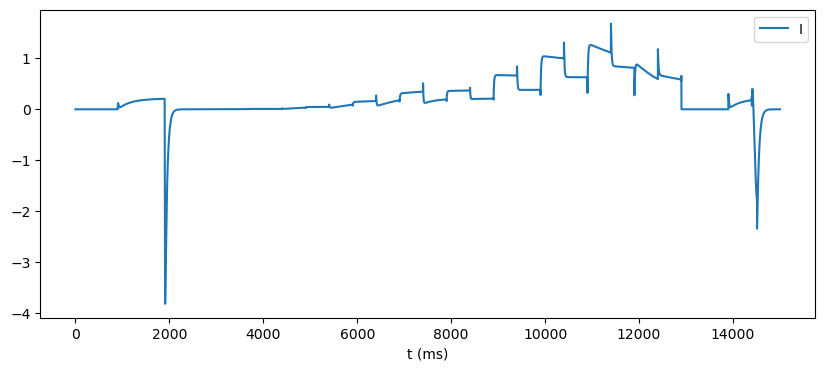

In [8]:
plt.figure(figsize=[10, 4])
plt.plot(ts, obsv(ts, ar_sol.sol(ts), p_true))
plt.legend('I')
plt.xlabel('t (ms)')

In [9]:
truth_synth = obsv(ts, ar_sol.sol(ts), p_true)

y_synth = (truth_synth * (1 + 0.05*np.random.randn(*truth_synth.shape)))

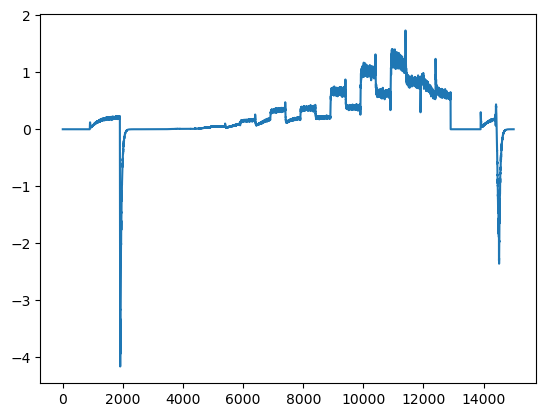

In [10]:
plt.plot(ts, y_synth)

In [11]:
def distance(p):
    x_ar = integrate.solve_ivp(ion_channel_model, tlim, y0, args=[p], dense_output=True)
    x_I = obsv(ts, x_ar.sol(ts), p)
    
    return np.linalg.norm(x_I - y_synth)**2

In [ ]:
optimize.minimize(distance, x0=np.random.rand(9))

